In [54]:
import os
import yfinance as yf
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

In [2]:
# Introduce Technical Indicators
def download_stock_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    df = df[['Open', 'High', 'Low', 'Close']]
    df['RSI'] = compute_rsi(df['Close'])
    df['SMA'] = df['Close'].rolling(window=14).mean()
    df['EMA'] = df['Close'].ewm(span=14).mean()
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    return df.dropna()

# Calculate RSI signals
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

# Define sentimental function
def apply_finbert(headlines):
    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    sentiments = []
    for text in headlines:
        inputs = tokenizer(text, return_tensors="pt", truncation=True)
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        sentiment_score = probs[0][2] - probs[0][0]  # pos - neg
        sentiments.append(sentiment_score.item())
    return sentiments

In [43]:
# StockFormer Model
class StockFormer(nn.Module):
    def __init__(self, input_dim, d_model=80, nhead=8, num_layers=6, dropout=0.1):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [seq_len, batch_size, input_dim]
        x = self.input_fc(x)  # linear projection
        x = self.transformer(x)  # transformer encoder
        out = self.output_fc(x[-1])  # last time step prediction
        return out.view(-1)

In [4]:
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error

def directional_accuracy(preds, targets):
    return ((preds[1:] - targets[:-1]) * (targets[1:] - targets[:-1]) > 0).float().mean().item()

def evaluate_model(model, dataloader, device, is_classification=False):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            preds.extend(output.cpu().numpy())
            targets.extend(y.cpu().numpy())

    preds = np.array(preds)
    targets = np.array(targets)

    r2 = r2_score(targets, preds)
    mse = mean_squared_error(targets, preds)
    da = directional_accuracy(torch.tensor(preds), torch.tensor(targets))

    results = {
        "R2": r2,
        "MSE": mse,
        "Directional Accuracy": da,
    }

    # AUC only applicable in binary classification
    if is_classification:
        # convert targets to binary 0/1 based on threshold
        targets_bin = (targets > np.median(targets)).astype(int)
        preds_proba = 1 / (1 + np.exp(-preds))  # sigmoid for probability
        try:
            auc = roc_auc_score(targets_bin, preds_proba)
            results["AUC"] = auc
        except:
            results["AUC"] = "Undefined (single class)"

    return results

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Step 1: Simulated Preprocessed Dataset 
N_SAMPLES = 1000
SEQ_LEN = 10
FEATURES = 7

np.random.seed(42)
X_sim = np.random.randn(N_SAMPLES, SEQ_LEN, FEATURES).astype(np.float32)
y_sim = (np.random.randn(N_SAMPLES) * 0.02 + 0.01).astype(np.float32)  # normalized open price

In [7]:
# Step 2: Dataset and Dataloader 
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


dataset = StockDataset(X_sim, y_sim)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
# Step 3: Simplified StockFormer Model 
class StockFormer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_fc(x)  # [seq_len, batch, d_model]
        x = self.transformer(x)
        out = self.output_fc(x[-1])  # last time step
        return out.squeeze()

In [9]:
# Step 4: Training loop with permuted input and full evaluation

def directional_accuracy(preds, targets):
    return ((torch.diff(preds) * torch.diff(targets)) > 0).float().mean().item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = StockFormer(input_dim=FEATURES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

loss_history, da_history = [], []
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    all_preds, all_targets = [], []

    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.permute(1, 0, 2)  

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.append(preds.detach().cpu())
        all_targets.append(yb.detach().cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    da = directional_accuracy(all_preds, all_targets)
    avg_loss = total_loss / len(dataloader)

    loss_history.append(avg_loss)
    da_history.append(da)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f} - Directional Accuracy: {da:.4f}")


C:\Users\chang\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10 - Loss: 0.1499 - Directional Accuracy: 0.4725
Epoch 2/10 - Loss: 0.0049 - Directional Accuracy: 0.5125
Epoch 3/10 - Loss: 0.0027 - Directional Accuracy: 0.5105
Epoch 4/10 - Loss: 0.0021 - Directional Accuracy: 0.5245
Epoch 5/10 - Loss: 0.0020 - Directional Accuracy: 0.4995
Epoch 6/10 - Loss: 0.0016 - Directional Accuracy: 0.5065
Epoch 7/10 - Loss: 0.0015 - Directional Accuracy: 0.5005
Epoch 8/10 - Loss: 0.0014 - Directional Accuracy: 0.4585
Epoch 9/10 - Loss: 0.0012 - Directional Accuracy: 0.4725
Epoch 10/10 - Loss: 0.0010 - Directional Accuracy: 0.4765


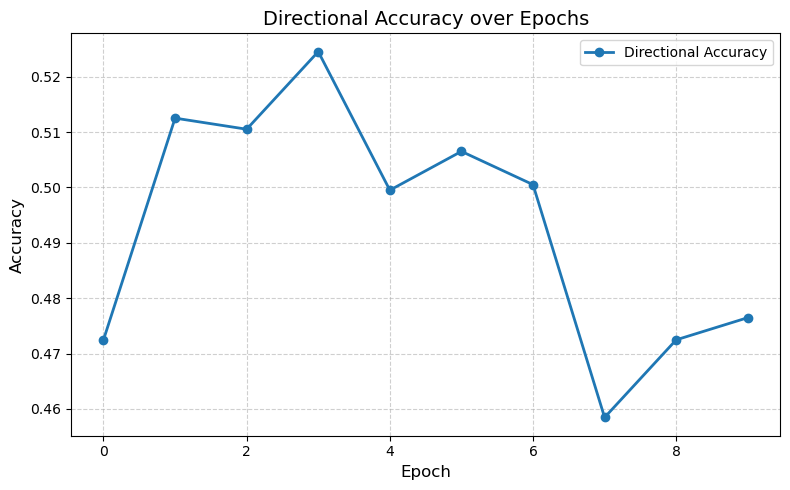

In [10]:
# Step 5: Plotting Accuracy Trend 
plt.figure(figsize=(8, 5))
plt.plot(da_history, label="Directional Accuracy", linewidth=2, marker='o')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Directional Accuracy over Epochs", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

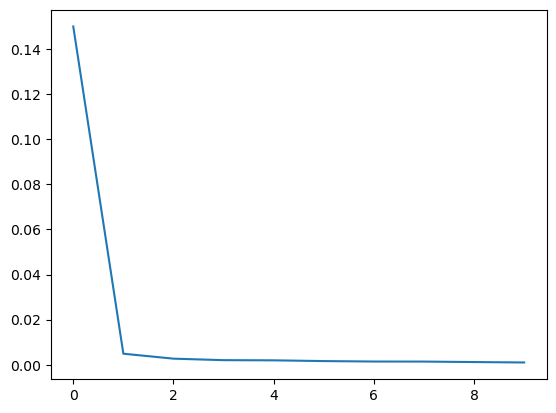

In [11]:
plt.plot(loss_history, label="Loss")

In [67]:
# Step 6: BiLSTMBaseline model
class BiLSTMBaseline(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=False,
            bidirectional=True
        )
        self.output_fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):  # x: [seq_len, batch, input_dim]
        out, _ = self.lstm(x)  # out: [seq_len, batch, 2*hidden_dim]
        out = self.output_fc(out[-1])  # use last time step
        return out[-1].view(-1)


In [68]:
model = BiLSTMBaseline(input_dim=FEATURES).to(device)

In [48]:
# Step 7: Empirical Analysis
df = pd.read_csv(r"C:\Users\chang\Desktop\NLP\SPY.csv")
df_news = pd.read_csv(r"C:\Users\chang\Desktop\NLP\Combined_News_DJIA.csv")

df.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year
0,1993-01-29,24.469912,24.469912,24.348171,24.452520,1003200,29,4,4,1,1993
1,1993-02-01,24.469918,24.626442,24.469918,24.626442,480500,1,0,5,2,1993
2,1993-02-02,24.609034,24.695992,24.556860,24.678600,201300,2,1,5,2,1993
3,1993-02-03,24.713392,24.956873,24.696000,24.939482,529400,3,2,5,2,1993
4,1993-02-04,25.026437,25.096004,24.748173,25.043829,531500,4,3,5,2,1993


In [56]:
def load_local_spy_data(path="C:/Users/chang/Desktop/NLP/SPY.csv"):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', 'Open', 'High', 'Low', 'Close']]
    df['RSI'] = compute_rsi(df['Close'])
    df['SMA'] = df['Close'].rolling(window=14).mean()
    df['EMA'] = df['Close'].ewm(span=14).mean()
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    return df.dropna()

def prepare_news_sentiment(news_path):
    df_news = pd.read_csv(news_path)
    df_news['Date'] = pd.to_datetime(df_news['Date'])

    news_columns = [f"Top{i}" for i in range(1, 26)]
    df_news["AllNews"] = df_news[news_columns].astype(str).apply(lambda row: ' '.join(row.values), axis=1)

    try:
        tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
        model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
        model.eval()
    except Exception as e:
        print(f" Failed to load FinBERT: {e}")
        df_news["Sentiment"] = 0.0
        return df_news[["Date", "Sentiment"]]

    sentiment_scores = []
    print("[] Scoring FinBERT Sentiment...")
    for text in tqdm(df_news["AllNews"], desc="FinBERT Scoring"):
        try:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)
                score = probs[0][2] - probs[0][0]
                sentiment_scores.append(score.item())
        except:
            sentiment_scores.append(0.0)

    df_news["Sentiment"] = sentiment_scores
    return df_news[["Date", "Sentiment"]]


def finalize_dataset(df_price, df_sentiment, out_path="data/sp500_preprocessed.csv"):
    
    df = pd.merge(df_price, df_sentiment, on="Date", how="left")
    df["Sentiment"].fillna(0.0, inplace=True)

    df["Target"] = df["Open"].shift(-1)
    df = df.dropna()

    features = ['Open', 'High', 'Low', 'Close', 'RSI', 'SMA', 'EMA', 'MACD', 'Sentiment']
    df[features] = (df[features] - df[features].mean()) / df[features].std()

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    df.to_csv(out_path, index=False)
    print(f" Data saved to: {out_path}")
    return df

df_price = load_local_spy_data("C:/Users/chang/Desktop/NLP/SPY.csv")
df_sentiment = prepare_news_sentiment("C:/Users/chang/Desktop/NLP/Combined_News_DJIA.csv")
df_final = finalize_dataset(df_price, df_sentiment)

[] Scoring FinBERT Sentiment...


FinBERT Scoring: 100%|██████████| 1989/1989 [10:27<00:00,  3.17it/s]

 Data saved to: data/sp500_preprocessed.csv



C:\Users\chang\AppData\Local\Temp\ipykernel_18568\2597418805.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Sentiment"].fillna(0.0, inplace=True)


In [57]:
df_final.head()

,Date,Open,High,Low,Close,RSI,SMA,EMA,MACD,Sentiment,Target
0,1993-02-18,-0.979297,-0.980914,-0.982186,-0.981425,-0.879990,-0.977310,-0.978302,-0.246405,0.530021,24.156861
1,1993-02-19,-0.981497,-0.982459,-0.979973,-0.980778,-0.710613,-0.977421,-0.978703,-0.251610,0.530021,24.313381
2,1993-02-22,-0.980332,-0.981558,-0.979062,-0.980131,-0.880013,-0.977579,-0.978941,-0.252661,0.530021,24.400345
3,1993-02-23,-0.979685,-0.981172,-0.979452,-0.980261,-1.014603,-0.977774,-0.979159,-0.253438,0.530021,24.330786
4,1993-02-24,-0.980203,-0.979626,-0.978411,-0.977931,-0.905185,-0.977940,-0.979006,-0.244560,0.530021,24.609034


In [58]:
def create_sliding_windows(df, feature_cols, target_col, window_size=10):
    X, y = [], []
    for i in range(len(df) - window_size - 1):
        X_window = df[feature_cols].iloc[i:i+window_size].values
        y_value = df[target_col].iloc[i + window_size]
        X.append(X_window)
        y.append(y_value)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

class StockDatasetReal(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)  
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [60]:
df = df_final
df.head()

,Date,Open,High,Low,Close,RSI,SMA,EMA,MACD,Sentiment,Target
0,1993-02-18,-0.979297,-0.980914,-0.982186,-0.981425,-0.879990,-0.977310,-0.978302,-0.246405,0.530021,24.156861
1,1993-02-19,-0.981497,-0.982459,-0.979973,-0.980778,-0.710613,-0.977421,-0.978703,-0.251610,0.530021,24.313381
2,1993-02-22,-0.980332,-0.981558,-0.979062,-0.980131,-0.880013,-0.977579,-0.978941,-0.252661,0.530021,24.400345
3,1993-02-23,-0.979685,-0.981172,-0.979452,-0.980261,-1.014603,-0.977774,-0.979159,-0.253438,0.530021,24.330786
4,1993-02-24,-0.980203,-0.979626,-0.978411,-0.977931,-0.905185,-0.977940,-0.979006,-0.244560,0.530021,24.609034


In [61]:
feature_cols = ['Open', 'High', 'Low', 'Close', 'RSI', 'SMA', 'EMA', 'MACD', 'Sentiment']
target_col = 'Target'

X_real, y_real = create_sliding_windows(df, feature_cols, target_col, window_size=10)

split_idx = int(len(X_real) * 0.8)
X_train, X_val = X_real[:split_idx], X_real[split_idx:]
y_train, y_val = y_real[:split_idx], y_real[split_idx:]


train_dataset = StockDatasetReal(X_train, y_train)
val_dataset = StockDatasetReal(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f" Sliding window dataset created: Train={len(train_dataset)} | Val={len(val_dataset)}")

 Sliding window dataset created: Train=6465 | Val=1617


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = StockFormer(input_dim=9).to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

EPOCHS = 10
loss_history, da_history = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    all_preds, all_targets = [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.permute(1, 0, 2)  # [batch, seq, feat] → [seq, batch, feat]

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.append(preds.detach().cpu())
        all_targets.append(yb.detach().cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    da = directional_accuracy(all_preds, all_targets)
    avg_loss = total_loss / len(train_loader)

    loss_history.append(avg_loss)
    da_history.append(da)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f} | Directional Accuracy: {da:.4f}")

C:\Users\chang\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Epoch 1/10] Loss: 9602.4533 | Directional Accuracy: 0.4958
[Epoch 2/10] Loss: 5247.9537 | Directional Accuracy: 0.4978
[Epoch 3/10] Loss: 3194.8652 | Directional Accuracy: 0.5159
[Epoch 4/10] Loss: 2958.2406 | Directional Accuracy: 0.4788
[Epoch 5/10] Loss: 2946.3777 | Directional Accuracy: 0.4915
[Epoch 6/10] Loss: 2944.0849 | Directional Accuracy: 0.5127
[Epoch 7/10] Loss: 2970.1597 | Directional Accuracy: 0.5054
[Epoch 8/10] Loss: 2943.7323 | Directional Accuracy: 0.4997
[Epoch 9/10] Loss: 2947.6180 | Directional Accuracy: 0.5057
[Epoch 10/10] Loss: 2944.5692 | Directional Accuracy: 0.5071


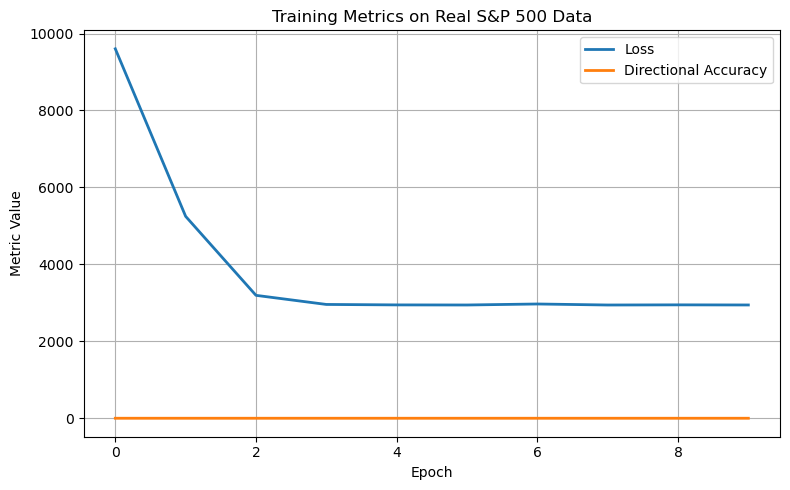

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(da_history, label="Directional Accuracy", linewidth=2)
plt.title("Training Metrics on Real S&P 500 Data")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
class BiLSTMBaseline(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=False,
            bidirectional=True
        )
        self.output_fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.output_fc(out[-1])  # out: [batch, 1]
        return out.squeeze(-1)         # 保证输出始终是 [batch]

# ---------- 方向准确率 ----------
def directional_accuracy(preds, targets):
    if len(preds) <= 1 or len(targets) <= 1:
        return 0.0
    return ((torch.diff(preds) * torch.diff(targets)) > 0).float().mean().item()

# ---------- 训练函数 ----------
def train_bilstm_model(X_train, y_train, X_val, y_val, input_dim, device, epochs=10, batch_size=32, lr=1e-3):
    model = BiLSTMBaseline(input_dim=input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_loader = DataLoader(StockDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(StockDataset(X_val, y_val), batch_size=batch_size)

    loss_history, da_history = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_targets = [], []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(1, 0, 2)  # [seq, batch, input_dim]

            optimizer.zero_grad()
            preds = model(xb)

            if preds.shape != yb.shape:
                continue  # skip bad batch

            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.append(preds.detach().cpu())
            all_targets.append(yb.detach().cpu())

        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        da = directional_accuracy(all_preds, all_targets)
        avg_loss = total_loss / len(train_loader)

        loss_history.append(avg_loss)
        da_history.append(da)

        print(f"[Epoch {epoch+1}/{epochs}] Loss: {avg_loss:.4f} | Directional Accuracy: {da:.4f}")

    return model, loss_history, da_history

In [71]:
model, bilstm_loss_history, bilstm_da_history = train_bilstm_model(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    input_dim=X_train.shape[2],
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    epochs=10
)

[Epoch 1/10] Loss: 9565.1546 | Directional Accuracy: 0.3844
[Epoch 2/10] Loss: 6267.5136 | Directional Accuracy: 0.3919
[Epoch 3/10] Loss: 4552.4369 | Directional Accuracy: 0.4033
[Epoch 4/10] Loss: 3742.3589 | Directional Accuracy: 0.4355
[Epoch 5/10] Loss: 3207.5067 | Directional Accuracy: 0.5144
[Epoch 6/10] Loss: 3031.5309 | Directional Accuracy: 0.6440
[Epoch 7/10] Loss: 2816.9870 | Directional Accuracy: 0.7877
[Epoch 8/10] Loss: 1773.9373 | Directional Accuracy: 0.9468
[Epoch 9/10] Loss: 1341.3810 | Directional Accuracy: 0.9575
[Epoch 10/10] Loss: 1031.0218 | Directional Accuracy: 0.9584


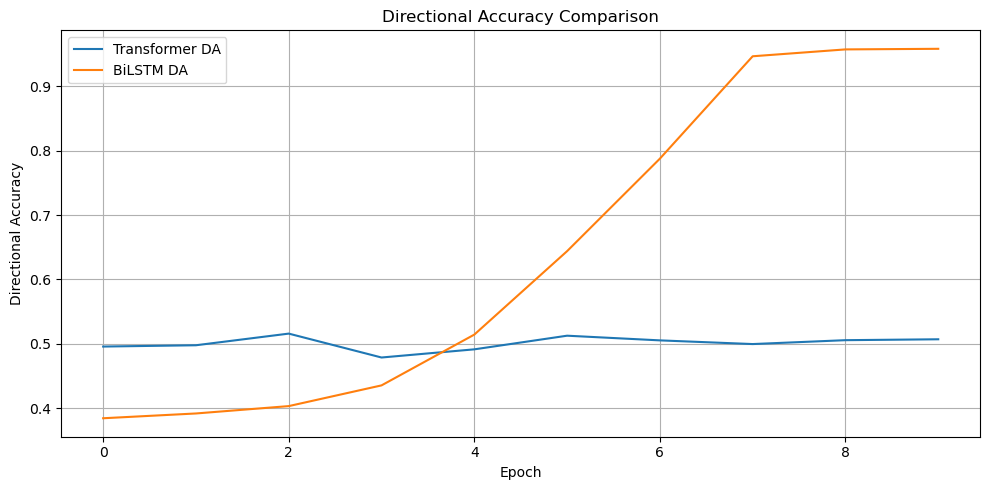

In [73]:
plt.figure(figsize=(10, 5))
plt.plot(da_history, label="Transformer DA")
plt.plot(bilstm_da_history, label="BiLSTM DA")
plt.xlabel("Epoch")
plt.ylabel("Directional Accuracy")
plt.title("Directional Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()